In [1]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb

%matplotlib inline

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
TOTAL_DAYS = 1913 + 28 * 2
ENC_LEN = 28
DEC_LEN = 28
MAX_LAGS = 28
TRAIN_LAST_DAY = 1913
FIRST_DAY = datetime(2011, 1, 29) 
FORECAST_DAY = datetime(2016,4, 25) 

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "int16", 'snap_TX': 'int16', 'snap_WI': 'int16' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [20]:
class DataLoader:
    
    def __init__(self, dir_path):
        self.dir_path = dir_path
        self.label_encoders = {}
    
    def load(self, nrows=None, first_day=1200):
        prices = pd.read_csv(os.path.join(self.dir_path, "sell_prices.csv"), dtype = PRICE_DTYPES)
        for col, col_dtype in PRICE_DTYPES.items():
            if col_dtype == "category":
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder().fit(prices[col].astype(str).fillna("None"))
                prices[col] = self.label_encoders[col].transform(prices[col].astype(str).fillna("None")).astype("int16")

        cal = pd.read_csv(os.path.join(self.dir_path, "calendar.csv"), dtype = CAL_DTYPES)
        cal["date"] = pd.to_datetime(cal["date"])
        for col, col_dtype in CAL_DTYPES.items():
            if col_dtype == "category":
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder().fit(cal[col].astype(str).fillna("None"))
                cal[col] = self.label_encoders[col].transform(cal[col].astype(str).fillna("None")).astype("int16")
        
        start_day = max(1, first_day)
        numcols = [f"d_{day}" for day in range(start_day, TRAIN_LAST_DAY+1)]
        catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
        dtype = {numcol:"float32" for numcol in numcols} 
        dtype.update({col: "category" for col in catcols if col != "id"})
        dt = pd.read_csv(os.path.join(self.dir_path, "sales_train_validation.csv"), 
                         nrows = nrows, usecols = catcols + numcols, dtype = dtype)
        
        for col in catcols:
            if col != "id":
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder().fit(dt[col].astype(str).fillna("None"))
                dt[col] = self.label_encoders[col].transform(dt[col].astype(str).fillna("None")).astype("int16")
                    
        for day in range(TRAIN_LAST_DAY+1, TRAIN_LAST_DAY+28+1):
            dt[f"d_{day}"] = np.nan
        
        dt = pd.melt(dt,
                      id_vars = catcols,
                      value_vars = [col for col in dt.columns if col.startswith("d_")],
                      var_name = "d",
                      value_name = "sales")

        dt = dt.merge(cal[['d', 'wm_yr_wk']], on= "d", copy = False)
        dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
        price = dt.pivot(index="id", columns="d", values="sell_price")
        xy = dt.pivot(index="id", columns="d", values="sales")
        del dt; gc.collect()
        
        cal_use_col = ['date', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI']
        cal = cal[cal_use_col]
        cal['year'] = cal['year'] - cal['year'].min()
        
        return xy, price, cal

In [21]:
xy, price, calendar = DataLoader("./data").load()

## 特征

### 时间序列状态
- 11_is_sell: 是否销售
- 10_is_zero: 是否为0销售
- 10_continue_zero: 为0第N天
- 10_lag_N：前N天销量
- 10_lag_M_rolling_N_mean/std: 窗口统计
- 品类销量
- 日期类

### 序列统计
- id 均值/中位数/偏度/峰度/分位数
- 365/90/30 自相关系数
- 品类下的日销排名/波动排名
- 品类下的价格排名

In [29]:
xy = xy.values
start_sell = np.argmin((xy == 0).values, axis=1)
xy_not_sell = np.zeros_like(xy)
for row, start in enumerate(start_sell):
    xy_not_sell[row][:start] = 1

In [48]:
xy_masked = np.ma.masked_array(xy, mask=xy_not_sell.astype(bool) | np.isnan(xy))

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


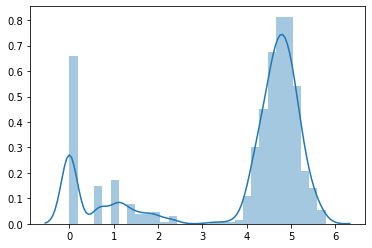

In [65]:
sns.distplot(np.log1p(xy)[7022, :-50])

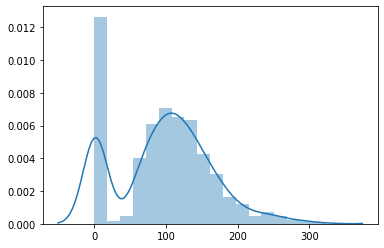

In [66]:
sns.distplot(xy[7022, :-50])

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


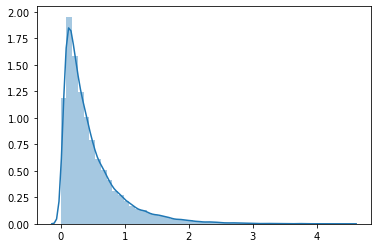

In [70]:
sns.distplot((np.log1p(xy_masked).mean(axis=1).data))

In [64]:
np.argmax(xy_masked.mean(axis=1).data)

7022

In [63]:
xy_masked.mean(axis=1).data.shape

(30490,)

In [50]:
xy_masked

masked_array(
  data=[[1.0, 2.0, 0.0, ..., --, --, --],
        [--, --, 1.0, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, 1.0, 0.0, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [ ]:
pad_end = np.argmin((sale == 0).values, axis=1)
is_zero = (sale == 0).values.astype(int)

for row, end in enumerate(pad_end):
    is_pad[row][:end] = 1
is_pad = np.zeros_like(sale)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
calendar = pd.read_csv("./data/calendar.csv").pipe(reduce_mem_usage)
price = pd.read_csv("./data/sell_prices.csv").pipe(reduce_mem_usage)
sale = pd.read_csv("./data/sales_train_validation.csv").pipe(reduce_mem_usage)
submission = pd.read_csv("./data/sample_submission.csv").pipe(reduce_mem_usage)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [20]:
calendar.wm_yr_wk.max()

11621

In [22]:
price.wm_yr_wk.max()

11621

In [24]:
calendar[calendar.wm_yr_wk == 11621]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [16]:
calendar.shape

(1969, 14)

In [7]:
price.head(2)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125


In [9]:
sale.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
submission.head(2)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 特征

### 时间序列状态
- 10_is_pad: 是否销售
- 10_is_zero: 是否为0销售
- 10_cum_zero: 连续销售为0第N天
- 

In [14]:
series_property = pd.DataFrame({"id": sale.id.unique()})
series_property = series_property.merge(sale[['id', 'item_id', 'dept_id', 'cat_id', 'store_id']], how='left')

In [27]:
id_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sale.drop(id_cols, axis=1, inplace=True)
sale.set_index("id", inplace=True)

In [52]:
pad_end = np.argmin((sale == 0).values, axis=1)
is_zero = (sale == 0).values.astype(int)

for row, end in enumerate(pad_end):
    is_pad[row][:end] = 1
is_pad = np.zeros_like(sale)

In [69]:
mask_series.mean(axis=1)

masked_array(data=[0.5928853754940712, 0.27853107344632766,
                   0.3564356435643564, ..., 0.895397489539749,
                   0.7207392197125256, 1.6973180076628354],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [98]:
sale = sale.apply(np.log1p)
mask_series = np.ma.array(sale.values, mask=is_pad)

# 统计特征 skew kurt

mu = mask_series.mean(axis=1).values
std = mask_series.std(axis=1).values
q5 = np.nanpercentile(mask_series.filled(np.nan), 5)
q95 = np.nanpercentile(mask_series.filled(np.nan), 95)

# 标准化序列

sale = (sale - mu.reshape(-1, 1)) / std.reshape(-1, 1)

# lag 序列

def lag(x, n):
    r = np.zeros_like(x)
    for row in range(x.shape[0]):
        r[row, n:] = x[row, :-n]
    return r

lag30 = lag(sale.values, 30)
lag90 = lag(sale.values, 90)
lag365 = lag(sale.values, 364) * 0.25 + lag(sale.values, 365) * 0.5 + lag(sale.values, 366) * 0.25

# 价格序列
# 日期序列
# 属性特征

(30490,)

In [17]:
calendar = calendar.rename({"snap_CA": "CA", "snap_TX": "TX", "snap_WI": "WI"}, axis=1)
calendar = calendar.melt(id_vars=calendar.columns[:-3], var_name="state_id", value_name="snap")

for col in ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]:
    calendar[col] = LabelEncoder().fit_transform(calendar[col].fillna("None"))
calendar["date"] = pd.to_datetime(calendar.date)
calendar["week"] = calendar.date.dt.week

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,state_id,snap,week
0,2011-01-29,11101,Saturday,1,1,2011,d_1,19,2,3,1,CA,0,4
1,2011-01-30,11101,Sunday,2,1,2011,d_2,19,2,3,1,CA,0,4
2,2011-01-31,11101,Monday,3,1,2011,d_3,19,2,3,1,CA,0,5
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,19,2,3,1,CA,1,5
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,19,2,3,1,CA,1,5


In [8]:
sale.shape

(30490, 1919)

In [4]:
NUM_ITEMS = sale.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28

In [5]:
for d in range(1914, 1942+DAYS_PRED):
    sale[f"d_{d}"] = np.nan

In [6]:
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sale = sale.melt(id_vars=id_cols, var_name="d", value_name="demand")
sale.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0


In [7]:
calendar = calendar.rename({"snap_CA": "CA", "snap_TX": "TX", "snap_WI": "WI"}, axis=1)
calendar = calendar.melt(id_vars=calendar.columns[:-3], var_name="state_id", value_name="snap")

In [8]:
for col in ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]:
    calendar[col] = LabelEncoder().fit_transform(calendar[col].fillna("None"))
calendar["date"] = pd.to_datetime(calendar.date)
calendar["week"] = calendar.date.dt.week

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,state_id,snap,week
0,2011-01-29,11101,Saturday,1,1,2011,d_1,19,2,3,1,CA,0,4
1,2011-01-30,11101,Sunday,2,1,2011,d_2,19,2,3,1,CA,0,4
2,2011-01-31,11101,Monday,3,1,2011,d_3,19,2,3,1,CA,0,5
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,19,2,3,1,CA,1,5
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,19,2,3,1,CA,1,5


In [9]:
merge = sale.merge(calendar.drop(["weekday"], axis=1), on=["d", "state_id"], how="left")
merge = merge.merge(price, on=["store_id", "item_id", "wm_yr_wk"], how="left")

In [10]:
merge.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN


In [11]:
for col in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    merge[col] = LabelEncoder().fit_transform(merge[col])

In [12]:
merge = reduce_mem_usage(merge)

Mem. usage decreased to 3091.70 Mb (41.9% reduction)


In [13]:
merge.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN


In [14]:
merge = merge.sort_values(['id', 'date']).reset_index(drop=True)

In [15]:
def drop_zero_ahead(df, col):
    first_idx = df[df[col] != 0].index[0]
    return df.iloc[first_idx:]

In [16]:
valid_merge = merge.groupby('id').apply(lambda group: drop_zero_ahead(group.reset_index(drop=True), 'demand'))

In [17]:
valid_merge = valid_merge.reset_index(drop=True)

In [18]:
valid_merge

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_1,3.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,2.000000
1,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_2,0.0,2011-01-30,11101,2,1,2011,19,2,3,1,0,4,2.000000
2,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_3,0.0,2011-01-31,11101,3,1,2011,19,2,3,1,0,5,2.000000
3,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_4,1.0,2011-02-01,11101,4,2,2011,19,2,3,1,1,5,2.000000
4,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_5,4.0,2011-02-02,11101,5,2,2011,19,2,3,1,1,5,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47649935,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1965,NaN,2016-06-15,11620,5,6,2016,19,2,3,1,1,24,5.941406
47649936,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1966,NaN,2016-06-16,11620,6,6,2016,19,2,3,1,0,24,5.941406
47649937,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1967,NaN,2016-06-17,11620,7,6,2016,19,2,3,1,0,24,5.941406
47649938,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1968,NaN,2016-06-18,11621,1,6,2016,19,2,3,1,0,24,5.941406


In [19]:
valid_merge['demand'] = np.log1p(valid_merge.demand)

In [20]:
mu = valid_merge.groupby('id')['demand'].mean().rename("mu")

In [21]:
std = valid_merge.groupby('id')['demand'].std().rename("std")

In [22]:
standar = pd.DataFrame(valid_merge['id']).merge(mu, on='id', how='left').merge(std, on='id', how='left')

In [25]:
valid_merge['demand'] = (valid_merge.demand.values - standar['mu'].values) / standar['std'].values

In [29]:
train = valid_merge[valid_merge.demand.notnull()]

In [ ]:
data = MultiSeriesData(x=train.demand.values.reshape(-1, 1), enc_len=365, dec_len=28, series_id=train.id)